# Ride Retention Challenge

Ultimate Technologies Inc. is an American worldwide online transportation network company headquartered in San Francisco, California. Founded by Jarvis Karolick in 2010, it has completely disrupted the taxi and logistics industry, and is one of the most prestigious companies to work for. This challenge has been adapted from an actual Ultimate Inc. data science challenge.

# Part 1 - Exploratory Data Analysis

The logins.json file contains timestamps of user logins in a particular geographic location. I aggregate these login counts based on 15-minute time intervals and visualize the time series of login counts by the hour of the day and by the day of the week. The following figures reveal both the daily and weekly cycles and a general upward trend over time.

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
% matplotlib inline

In [2]:
logins = pd.read_json('logins.json')

In [3]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
logins = logins.sort_values('login_time').set_index('login_time')
logins['count'] = 1
logins = logins.resample('15T').sum().fillna(0)

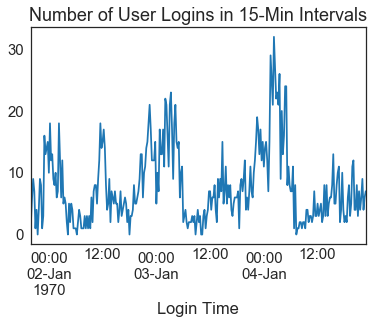

In [5]:
logins.head(300).plot(legend=False)
plt.title('Number of User Logins in 15-Min Intervals')
plt.xlabel('Login Time')
plt.show()

## Daily Cycle by the Hour of the Day

Users are most active in the evening from 8pm to 5am and around noon time from 11am to 2pm. There are very few active users in the morning between 6am and 10am.

In [6]:
hourly_logins = logins.resample('1H').sum()
hourly_logins['hour'] = hourly_logins.index.hour

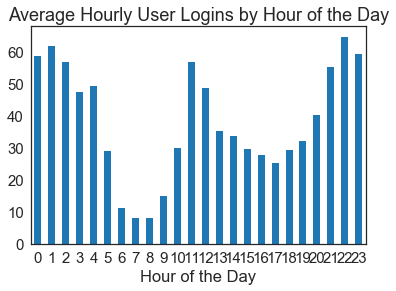

In [7]:
hourly_logins.groupby('hour').mean().plot(kind='bar', legend=False)
plt.title('Average Hourly User Logins by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.xticks(range(0,24), rotation=0)
plt.show()

## Weekly Cycle by the Day of the Week

Looking at the daily user logins, there is a slight upward trend with a cyclical pattern depending on the day of the week, and the weekly variance increases over time.

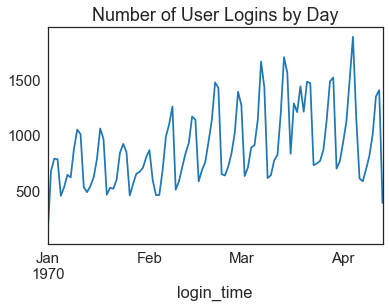

In [8]:
daily_logins = logins.resample('1D').sum()
daily_logins.plot(legend=False)
plt.title("Number of User Logins by Day")
plt.show()

## The Day of the Week Pattern

Looking at the cycle depending on the day of the week, the user logins on average are higher on Firday, Saturday and Sunday than other days of the week.

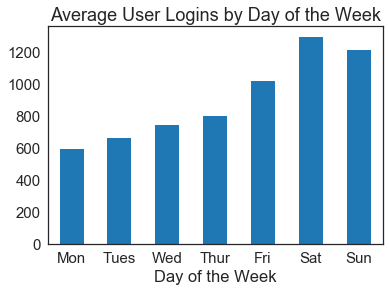

In [9]:
daily_logins['dayofweek'] = daily_logins.index.dayofweek
labels = ['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
ax = daily_logins.groupby('dayofweek')['count'].mean().plot(kind='bar', legend=False)
ax.set_xticklabels(labels, rotation=0)
plt.title('Average User Logins by Day of the Week')
plt.xlabel('Day of the Week')
plt.show()

## Weekly Variation across All 16 Weeks

The scatterplot of daily user logins by day of the week across all 16 weeks shows a few outliers. First, the user logins on Thursday in week 1 is unusally low becasue the data is only available after 8pm on January 1, 1970. Similarly, the last day included in the dataset is Monday in week 16, April 13, 1970, and there is no data available after 7pm. The user logins in week 12 are the highest from Monday to Thursday, which are March 16-19. The user logins in week 14 are the highest on Friday and Saturday, April 3-4.

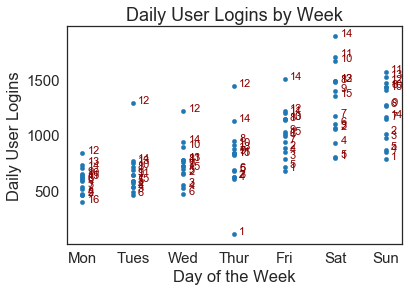

In [10]:
daily_logins['week'] = daily_logins.index.week
ax = daily_logins.plot(x='dayofweek', y='count', kind='scatter', xticks=range(0,7))
ax.set_xticklabels(labels)

font = {'color':'darkred','size': 11}
for i, point in daily_logins.iterrows():
    ax.text(point['dayofweek']+0.1, point['count'], str(int(point['week'])), fontdict=font)

plt.title('Daily User Logins by Week')
plt.ylabel('Daily User Logins')
plt.xlabel('Day of the Week')
plt.show()

# Part 2 - Experiment and Metrics Design

Gotham and Metropolis are two neighboring cities that have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

#### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Answer: Perhaps when Gotham is active at night, there are not enough drivers to meet the total demand because drivers in Metropolis are not willing to cross the bridge and incur the toll costs and vice versa. Reimbursing toll costs should encourage more drivers to give rides in whichever city that is most active at the time. We can measure the revenue gained from the additional driver activities in Gotham on any weekday evening and that in Metropolis on any weekday day time minus the total reimbursement cost during a specific period. If the revenue minus cost is greater than zero, the experiment is succssful.

#### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

Answer: The experiment should include a control group and a treatment group. We should randomly select some drivers to be in the treatment group where they are told that they would be reimbursed for all toll costs for one week. The control group is another random sample that is chosen for the same week but without reimbursement of toll costs. Randomization is important for ensuring that when the sample size is sufficiently large the two groups would become independent so that the distribution of personal characteristics, such as race, gender and years of education, would be statistically identical for the two groups. This allows us to attribute the cause of any difference in driver behavior between the two groups to the only treatment variable that is to reimburse toll costs and not to differences in sample characteristics.

To test whether the experiment is successful in influencing driver activities, we can first check whether the total driver activities are higher in the treatment group than in the control group by using a two-sample t-test in whichever city that is most active at the time. Then we should test whether the additional revenue gained from increased activities in the treatment group is significantly greater the total reimbursement cost.

The results might be that the additional revenue is greater than reimbursement cost only during the weekday day time to meet the high demand in Metropolis. Then I would recommend the city operations team to reimburse toll costs only during the day in a weekday. Therefore, the implementation of the new policy will be city-specific and time-specific, depending its profitability.

# Part 3 Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1.Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2.Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3.Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

## Data description

city: city this user signed up in

phone: primary device for this user

signup_date: date of account registration; in the form ‘YYYYMMDD’

last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

avg_dist: the average distance in miles per trip taken in the first 30 days after signup

avg_rating_by_driver: the rider’s average rating over all of their trips

avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

surge_pct: the percent of trips taken with surge multiplier > 1

avg_surge: The average surge multiplier over all of this user’s trips

trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

weekday_pct: the percent of the user’s trips occurring during a weekday

In [11]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)

In [12]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [13]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

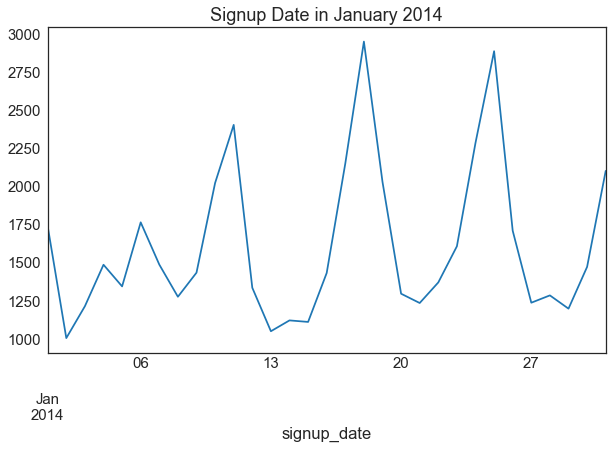

In [14]:
df.groupby('signup_date').size().plot(figsize=(10,6))
plt.title('Signup Date in January 2014')
plt.show()

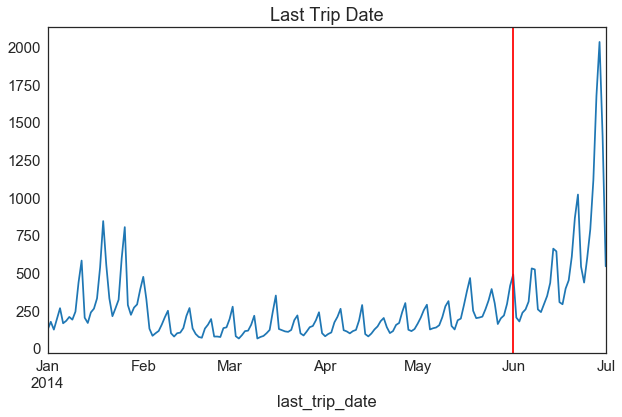

In [15]:
df.groupby('last_trip_date').size().plot(figsize=(10,6))
plt.axvline(x='2014-06-01', color='red')
plt.title('Last Trip Date')
plt.show()

User Retention: A user is retained if the date of the last trip is on or after June 1, 2014 (which is within 30 days preceding July 1, 2014).

In [16]:
df['retain'] = (df.last_trip_date >= '2014-06-01')
frac_retain = df.retain.sum() / df.shape[0]
print('The fraction of users that are retained is {:.1f}%.'.format(frac_retain*100))

The fraction of users that are retained is 37.6%.


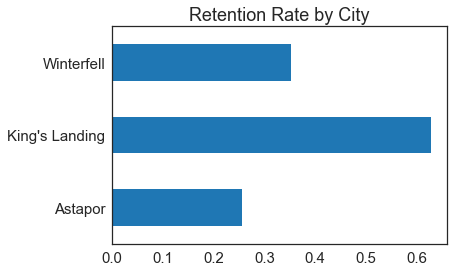

In [17]:
df.groupby('city')['retain'].mean().plot(kind='barh')
plt.title("Retention Rate by City")
plt.ylabel('')
plt.show()

In [18]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


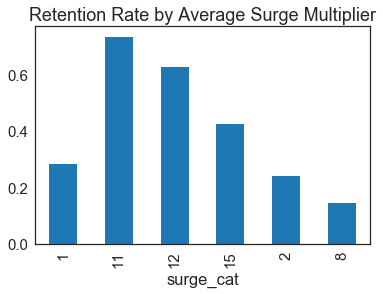

In [19]:
# surge multiplier increases fares during times of high demand for rides

df['avg_surge_1'] = (df['avg_surge']==1)

df['surge_cat'] = pd.cut(df['avg_surge'], 
                         (0, 1, 1.1, 1.2, 1.5, 2, 8),
                         labels=['1', '11', '12', '15', '2', '8'])
df.groupby('surge_cat')['retain'].mean().plot(kind='bar')
plt.title("Retention Rate by Average Surge Multiplier")
plt.show()

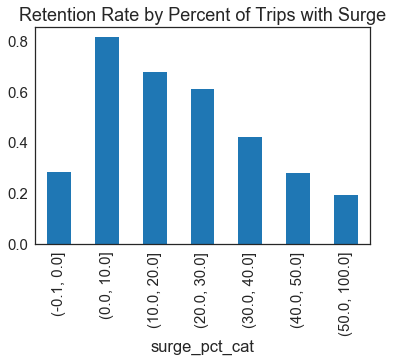

In [20]:
# Retention rate falls as percentage of trips with surge rises except when it is zero
df['surge_pct_0'] = (df['surge_pct'] == 0)

df['surge_pct_cat'] = pd.cut(df['surge_pct'], 
                             (-0.1, 0, 10, 20, 30, 40, 50, 100))
df.groupby('surge_pct_cat')['retain'].mean().plot(kind='bar')
plt.title("Retention Rate by Percent of Trips with Surge")
plt.show()

In [21]:
df.groupby(['surge_pct_0','avg_surge_1']).size()

surge_pct_0  avg_surge_1
False        False          15546
             True              45
True         True           34409
dtype: int64

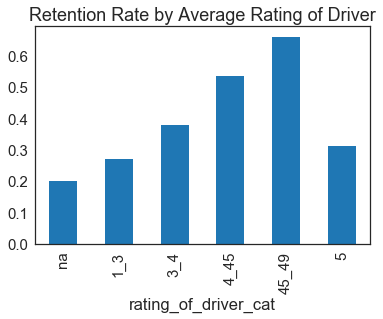

In [22]:
df['rating_of_driver_cat'] = pd.cut(df['avg_rating_of_driver'].fillna(-99), 
                                    (-100, 0, 3, 4, 4.5, 4.9, 5),
                                    labels=['na', '1_3', '3_4', '4_45' ,'45_49', '5'])
df.groupby('rating_of_driver_cat')['retain'].mean().plot(kind='bar')
plt.title("Retention Rate by Average Rating of Driver")
plt.show()

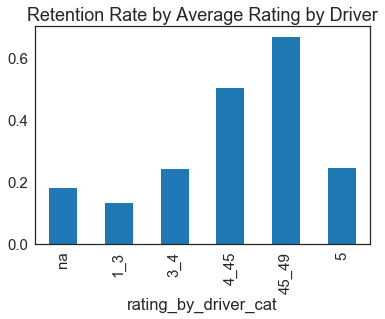

In [23]:
df['rating_by_driver_cat'] = pd.cut(df['avg_rating_by_driver'].fillna(-99), 
                                    (-100, 0, 3, 4, 4.5, 4.9, 5),
                                    labels=['na', '1_3', '3_4', '4_45' ,'45_49', '5'])
df.groupby('rating_by_driver_cat')['retain'].mean().plot(kind='bar')
plt.title("Retention Rate by Average Rating by Driver")
plt.show()

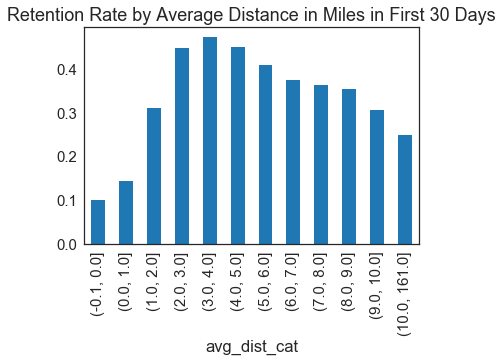

In [24]:
df['avg_dist_cat'] = pd.cut(df['avg_dist'], (-0.1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 161))
df.groupby('avg_dist_cat')['retain'].mean().plot(kind='bar')
plt.title("Retention Rate by Average Distance in Miles in First 30 Days")
plt.show()

In [25]:
df['avg_dist_2'] = (df['avg_dist'] <= 2)
df['log_avg_dist'] = np.log(df['avg_dist'] + 1)

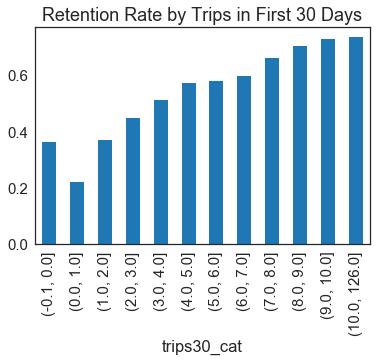

In [26]:
df['trips30_cat'] = pd.cut(df['trips_in_first_30_days'], (-0.1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 126))
df.groupby('trips30_cat')['retain'].mean().plot(kind='bar')
plt.title("Retention Rate by Trips in First 30 Days")
plt.show()

In [27]:
df['trips_0'] = (df['trips_in_first_30_days'] == 0)
df['log_trips'] = np.log(df['trips_in_first_30_days'] + 1)

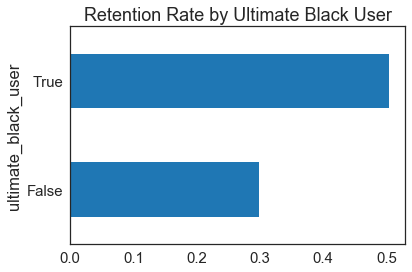

In [28]:
df.groupby('ultimate_black_user')['retain'].mean().plot(kind='barh')
plt.title('Retention Rate by Ultimate Black User')
plt.show()

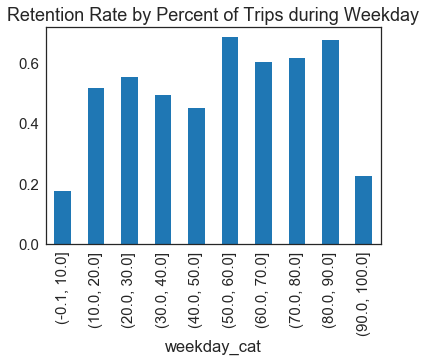

In [29]:
df['weekday_cat'] = pd.cut(df['weekday_pct'], 10)
df.groupby('weekday_cat')['retain'].mean().plot(kind='bar')
plt.title("Retention Rate by Percent of Trips during Weekday")
plt.show()

In [30]:
df['weekday_90'] = (df['weekday_pct']>90)
df['weekday_10'] = (df['weekday_pct']<=10)

In [31]:
df['phone'] = df['phone'].fillna('nan')
df['city'] = df['city'].map({"King's Landing" : "kings", 
                             "Astapor" : "astapor", 
                             "Winterfell": 'winterfell'})

## Predicting User Retention in the 6th Month

We have a classfication problem where we want to know why some users continue to use the service in their 6th month while others don't. My initial approach is to use logistic regression so that I can infer which features are important for predicting retention. The model performs reasonably well, as the area under the ROC curve is 0.84, which is much larger than the 0.5 of random assignment.

From the model results, we can see that users are more likely to remain active in their 6th month if they were ultimate black users in their first 30 days, if they lived in King’s Landing or Winterfell, if they were iPhone users, if their average rating by drivers or of drivers were between 4 and 4.9, if they took more trips in their first 30 days, if their average distance per trip were between 2 and 5 miles, and if their average surge multiplier over all trips were between 1 and 1.5.

Users are less likely to remain active if they took trips only during weekdays or only during weekends, if their average distance per trip were less than 2 miles, if their average surge multiplier were exactly one or greater than 2, if their average rating by or of drivers were less than 3 or exactly 5, if they lived in Astapor, if they were Android users, and if they were not ultimate black users.

From the 5 fold cross validation results, the area under the ROC curve for the out-of-fold predictions ranges from 0.83-0.85, so the model does well in predicting unseen data as well.

To increase long-term rider retention, Ultimate might want to:

1.improve the Android app and the user experience.

2.offer new users an Ultimate Black experience.

3.scale back surge multiplier whenever it rises above 2.

4.send out surveys to those users who consistently give out low rating of their drivers.

5.encourage users to take more trips in their first 30 days by offering discounts.

In [32]:
X = pd.get_dummies(df[['city', 'phone', 'ultimate_black_user', 
                       'weekday_pct', 'weekday_90', 'weekday_10', 
                       'log_trips', 'trips_0', 
                       'log_avg_dist', 'avg_dist_2',
                       'rating_by_driver_cat', 'rating_of_driver_cat',
                       'surge_cat']], 
                     drop_first=True)
print(X.shape)
print(X.columns)

(50000, 27)
Index(['ultimate_black_user', 'weekday_pct', 'weekday_90', 'weekday_10',
       'log_trips', 'trips_0', 'log_avg_dist', 'avg_dist_2', 'city_kings',
       'city_winterfell', 'phone_iPhone', 'phone_nan',
       'rating_by_driver_cat_1_3', 'rating_by_driver_cat_3_4',
       'rating_by_driver_cat_4_45', 'rating_by_driver_cat_45_49',
       'rating_by_driver_cat_5', 'rating_of_driver_cat_1_3',
       'rating_of_driver_cat_3_4', 'rating_of_driver_cat_4_45',
       'rating_of_driver_cat_45_49', 'rating_of_driver_cat_5', 'surge_cat_11',
       'surge_cat_12', 'surge_cat_15', 'surge_cat_2', 'surge_cat_8'],
      dtype='object')


In [33]:
y = df['retain']

In [34]:
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import KFold, 

clf = LogisticRegression(n_jobs=-1)
clf.fit(X, y)

C:\Users\yepeng\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:, 1])
auc = roc_auc_score(y, clf.predict_proba(X)[:, 1])

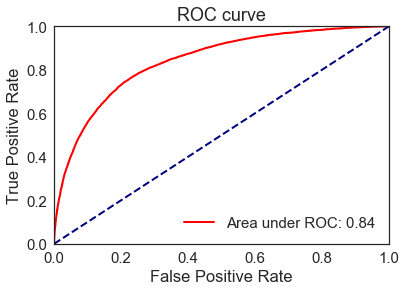

In [36]:
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='Area under ROC: {:.2f}'.format(auc))
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC curve')
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, clf.predict(X))
cm = cm/cm.sum(axis=1)
cm

array([[ 0.85757789,  0.23627951],
       [ 0.21515579,  0.64305467]])

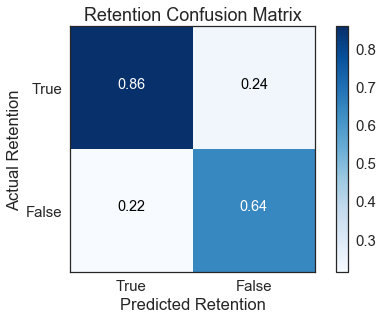

In [38]:
import itertools

plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(2), ['True', 'False'])
plt.yticks(np.arange(2), ['True', 'False'])
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment="center",
             fontsize='x-large',
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.title('Retention Confusion Matrix')
plt.ylabel('Actual Retention')
plt.xlabel('Predicted Retention')
plt.show()

In [39]:
coef = list(zip(X.columns, clf.coef_[0]))
pd.DataFrame(coef, columns=['feature', 'coefficient'])

,feature,coefficient
0,ultimate_black_user,0.812449
1,weekday_pct,0.004082
2,weekday_90,-1.043704
3,weekday_10,-0.724432
4,log_trips,0.059562
5,trips_0,0.711785
6,log_avg_dist,-0.175460
7,avg_dist_2,-0.546616
8,city_kings,1.889720
9,city_winterfell,0.577317


In [40]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
all_columns = '+'.join(X.columns)
df2 = X.copy()
df2['retain'] = y.astype(int)
formula = 'retain ~ ' + all_columns
logit = smf.glm(formula=formula, data=df2, family=sm.families.Binomial())
result = logit.fit()
print(result.summary())

C:\Users\yepeng\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 retain   No. Observations:                50000
Model:                            GLM   Df Residuals:                    49972
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -23654.
Date:                Fri, 23 Mar 2018   Deviance:                       47308.
Time:                        10:58:38   Pearson chi2:                 4.99e+04
No. Iterations:                     5                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -2.6074      0.218    -11.945      0.000      -3.035      -2.180
u

In [41]:
from sklearn.model_selection import StratifiedKFold

print('5 Fold Cross Validation on Area under the ROC Curve')
skf = StratifiedKFold(n_splits=5, random_state=0)
for train, test in skf.split(X, y):
    logit = LogisticRegression()
    #print(X.loc[train].shape, y.loc[train].shape)
    logit.fit(X.loc[train], y.loc[train])
    auc1 = roc_auc_score(y.loc[train], clf.predict_proba(X.loc[train])[:, 1])
    auc2 = roc_auc_score(y.loc[test], clf.predict_proba(X.loc[test])[:, 1])
    print('Train: {:.2f}. Test: {:.2f}'.format(auc1, auc2))

5 Fold Cross Validation on Area under the ROC Curve
Train: 0.84. Test: 0.84
Train: 0.84. Test: 0.84
Train: 0.84. Test: 0.83
Train: 0.84. Test: 0.84
Train: 0.84. Test: 0.85
